In [2]:
#Load and inspect the data
library(tidyverse)
library(tidymodels)
library(lubridate)

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

head(players)
head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


# Introduction

Understanding how different player characteristics relate to gameplay experience is essential for designing engaging game environments and tailoring content to different player groups. In behavioral game analytics, experience level is often used as a proxy for proficiency, engagement, or familiarity with game mechanics. Identifying factors that correlate with experience level can help inform game balancing, player retention strategies, and the design of personalized player experiences.

In this project, we analyze player information and gameplay behaviour using two data sources: a player dataset containing demographic variables and a session dataset containing gameplay durations. Our research question is:

**Does a player’s gender and total play time relate to their experience level?**

To answer this question, we examine whether total accumulated play time and gender distribution differ across experience groups. By summarizing and visualizing the relationships between these variables, we aim to uncover meaningful differences across player types.

# Methods & Results

Reads the CSV files into data frames first. The summary confirms 196 players and 1,535 raw sessions as noted. 

**1. Wrangling + Cleaning**

First we need to convert timestamps to datetime. However, the raw time stamps cannot be converted using **as_datetime()** because the format is non-ISO.
We therefore extract hour, minute, date manually using **separate()**.

In [4]:
# Separate start time into date and time components
sessions_data_clean1 <- sessions |>
  separate(start_time, into = c("date_raw", "time_raw"), sep = " ") |>
  separate(end_time,   into = c("date_raw_end", "time_raw_end"), sep = " ")

# Extract hour + minute
sessions_data_clean2 <- sessions_data_clean1 |>
  separate(time_raw, into = c("start_hour", "start_minute"), sep = ":") |>
  separate(time_raw_end, into = c("end_hour", "end_minute"), sep = ":")

# Convert hour/minute to numeric
sessions_data_clean <- sessions_data_clean2 |>
  mutate(
    start_hour = as.numeric(start_hour),
    end_hour = as.numeric(end_hour)
  )

head(sessions_data_clean)

hashedEmail,date_raw,start_hour,start_minute,date_raw_end,end_hour,end_minute,original_start_time,original_end_time
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18,12,30/06/2024,18,24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23,33,17/06/2024,23,46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17,34,25/07/2024,17,57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,3,22,25/07/2024,3,58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16,01,25/05/2024,16,12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024,15,08,23/06/2024,17,10,1.71916e+12,1.71916e+12


In [7]:
#Compute session duration (diff_time)
sessions_time_only <- sessions_data_clean |>
  mutate(
    diff_time = as.numeric(end_hour - start_hour)
  )

#Select cleaned session variables
sessions_data_tidy <- sessions_time_only |>
  select(hashedEmail, start_hour, end_hour, diff_time)

head(sessions_data_tidy)

hashedEmail,start_hour,end_hour,diff_time
<chr>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,18,18,0
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,23,23,0
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,17,17,0
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,3,3,0
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,16,16,0
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,15,17,2


The players_data table contains demographic and experience-related attributes describing each user. Variables such as experience and gender are categorical. To ensure proper treatment in grouping, plotting, or modeling, these fields were converted into factor types using **as_factor()**.

In [9]:
#Tidy players data
players_tidy <- players |>
  mutate(
    experience = as_factor(experience),
    gender = as_factor(gender)
  )
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


For player data set, compute the mean of each numeric variable in players.csv first. This helps identify overall trends in player attributes such as age and playtime. Then explore playtime differences by subscription status: subscription type may correlate with play intensity or session frequency. 

In [15]:
#Calculate players mean
player_means <- players_tidy |>
  summarize(across(where(is.numeric), mean, na.rm = TRUE)) |>
  pivot_longer(cols = everything(),
               names_to = "Variable",
               values_to = "Mean")
player_means

Variable,Mean
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


Finally, we merge players and sessions data together to incorporate demographic variables, experience and play time for each player.

In [16]:
#Merge players and sessions
merged_all <- merge(sessions_data_tidy, players_tidy,
                    by = "hashedEmail", all = TRUE)

#Remove players with no sessions
merged_sessions <- merged_all |>
  filter(!is.na(start_hour))

head(merged_sessions)

,hashedEmail,start_hour,end_hour,diff_time,experience,subscribe,played_hours,name,gender,Age
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<dbl>,<chr>,<fct>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,0,1,1,Regular,TRUE,1.5,Isaac,Male,20
2,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,23,0,-23,Regular,TRUE,1.5,Isaac,Male,20
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,4,4,0,Pro,FALSE,0.4,Lyra,Male,21
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,21,21,0,Beginner,TRUE,0.1,Osiris,Male,17
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,22,23,1,Regular,TRUE,5.6,Winslow,Male,17
6,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,21,22,1,Regular,TRUE,5.6,Winslow,Male,17


**2. Summary of the data set which is relevant for exploratory data analysis related to the planned analysis**

Our research question focuses on whether a player’s **gender** and **total play time** are related to their **experience level**. Because all three variables (gender, experience, total play time) are player-level characteristics, we must first convert the sessions dataset—which contains one row per game session—into a dataset where **each row represents exactly one player**.
This requires aggregating all sessions belonging to the same player into a single summarized record. Session-level data cannot be used directly for comparing players because:

1. **Multiple observations per player** cause statistical dependence and would artificially inflate sample size.
2. **Experience level and gender** are properties of the player, not individual sessions.
3. To compare total play time across experience groups, we need each player to have:
   - total time spent playing,
   - number of sessions,
   - average session duration,
   - and median session duration (a robust measure unaffected by extreme values).

Creating player-level summaries ensures one row per player, which is consistent with our analysis unit.

For each player, we compute:

- **sessions_num** — how many sessions the player has played  
  (a measure of activity)
- **total_time** — total time spent playing across all sessions  
  (the variable directly related to our research question)
- **mean_time** — average session duration  
  (helps describe typical session length)
- **median_time** — median session duration  
  (less sensitive to extreme session lengths)

These variables describe a player’s overall engagement with the game.

Although players have a `name` variable, multiple players may share the same name. `hashedEmail` is a unique and anonymized identifier for each player, so using it ensures sessions are grouped correctly, and data from different players is never mixed. Thus, all summarization and joining operations use `hashedEmail` as the primary key.

In [22]:
#Keep only relevant variables for aggregation
sessions_names_only <- merged_sessions |>
  select(hashedEmail, name, diff_time)

#Count number of sessions per player
sessions_count <- sessions_names_only |>
  group_by(hashedEmail, name) |>
  summarize(sessions_num = n())

#Compute total play time per player
total_time <- sessions_names_only |>
  group_by(hashedEmail, name) |>
  summarize(total_time = sum(diff_time, na.rm = TRUE))

#Compute mean & median session length per player
time_stats <- sessions_names_only |>
  group_by(hashedEmail, name) |>
  summarize(
    mean_time = mean(diff_time, na.rm = TRUE),
    median_time = median(diff_time, na.rm = TRUE)
  )

#Merge summaries
sessions_by_player_time <- merge(sessions_count, total_time,
                            by = c("hashedEmail", "name"), all.x = TRUE)
sessions_by_player <- merge(sessions_by_player_time, time_stats,
                            by = c("hashedEmail", "name"), all.x = TRUE)

player_level <- merge(players, sessions_by_player,
                      by = c("hashedEmail", "name"), all.x = TRUE)

head(player_level)

`summarise()` has grouped output by 'hashedEmail'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'hashedEmail'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'hashedEmail'. You can override using the
`.groups` argument.


,hashedEmail,name,experience,subscribe,played_hours,gender,Age,sessions_num,total_time,mean_time,median_time
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Isaac,Regular,TRUE,1.5,Male,20,2,-22,-11.0000000,-11
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Frankie,Veteran,TRUE,0.0,Male,17,NA,NA,NA,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Lyra,Pro,FALSE,0.4,Male,21,1,0,0.0000000,0
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Osiris,Beginner,TRUE,0.1,Male,17,1,0,0.0000000,0
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Winslow,Regular,TRUE,5.6,Male,17,13,5,0.3846154,0
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Knox,Pro,TRUE,1.0,Male,17,2,2,1.0000000,1


**3.Exploratory Data Analysis and visualizations**

In [26]:
# Gender distribution
player_level |>
  count(gender)

# Experience distribution
player_level |>
  count(experience)

# Summary of total play time by experience group
player_level |>
  group_by(experience) |>
  summarize(
    mean_total = mean(total_time),
    median_total = median(total_time)
  )

head(player_level)

gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


experience,mean_total,median_total
<chr>,<dbl>,<dbl>
Amateur,NA,NA
Beginner,NA,NA
Pro,NA,NA
Regular,NA,NA
Veteran,NA,NA


,hashedEmail,name,experience,subscribe,played_hours,gender,Age,sessions_num,total_time,mean_time,median_time
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Isaac,Regular,TRUE,1.5,Male,20,2,-22,-11.0000000,-11
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Frankie,Veteran,TRUE,0.0,Male,17,NA,NA,NA,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Lyra,Pro,FALSE,0.4,Male,21,1,0,0.0000000,0
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Osiris,Beginner,TRUE,0.1,Male,17,1,0,0.0000000,0
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Winslow,Regular,TRUE,5.6,Male,17,13,5,0.3846154,0
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Knox,Pro,TRUE,1.0,Male,17,2,2,1.0000000,1


**Visualization 1: Total play time by experience level**. This boxplot allows us to compare whether more experienced players accumulate more play time.
Differences in medians and spread reflect behavior patterns across groups.

Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


,hashedEmail,name,experience,subscribe,played_hours,gender,Age,sessions_num,total_time,mean_time,median_time
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Isaac,Regular,TRUE,1.5,Male,20,2,-22,-11.0000000,-11
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Frankie,Veteran,TRUE,0.0,Male,17,NA,NA,NA,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Lyra,Pro,FALSE,0.4,Male,21,1,0,0.0000000,0
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Osiris,Beginner,TRUE,0.1,Male,17,1,0,0.0000000,0
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Winslow,Regular,TRUE,5.6,Male,17,13,5,0.3846154,0
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Knox,Pro,TRUE,1.0,Male,17,2,2,1.0000000,1


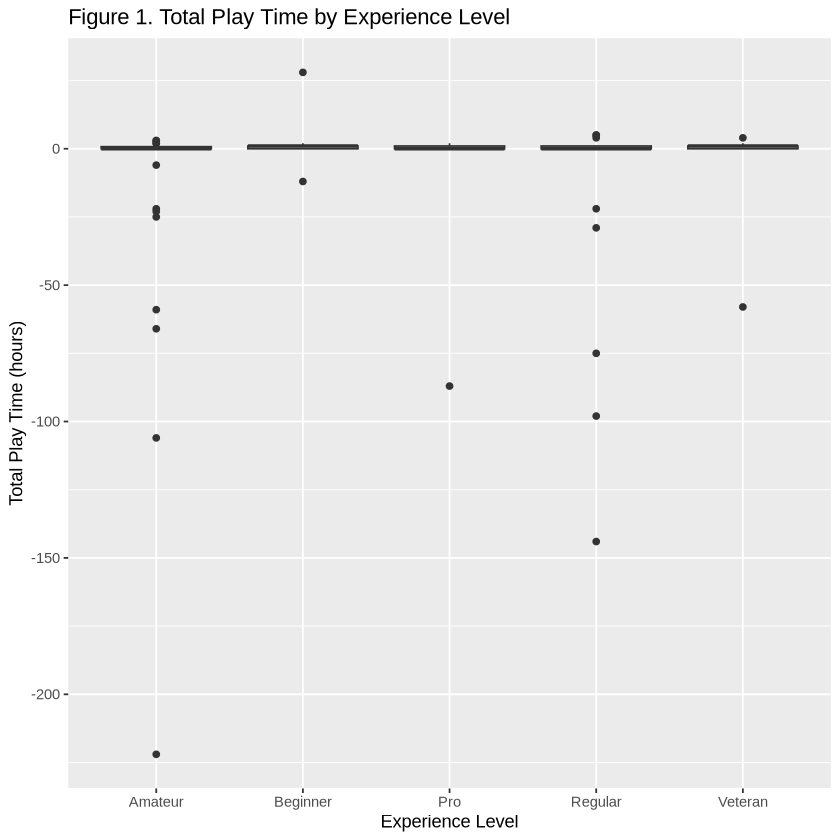

In [28]:
player_level |> ggplot(aes(x = experience, y = total_time)) +
  geom_boxplot() +
  labs(
    title = "Figure 1. Total Play Time by Experience Level",
    x = "Experience Level",
    y = "Total Play Time (hours)"
  )

head(player_level)

**Visualization 2: Gender distribution across experience levels**. This bar plot indicates whether certain genders are more represented in higher experience groups.

,hashedEmail,name,experience,subscribe,played_hours,gender,Age,sessions_num,total_time,mean_time,median_time
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Isaac,Regular,TRUE,1.5,Male,20,2,-22,-11.0000000,-11
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Frankie,Veteran,TRUE,0.0,Male,17,NA,NA,NA,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Lyra,Pro,FALSE,0.4,Male,21,1,0,0.0000000,0
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Osiris,Beginner,TRUE,0.1,Male,17,1,0,0.0000000,0
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Winslow,Regular,TRUE,5.6,Male,17,13,5,0.3846154,0
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Knox,Pro,TRUE,1.0,Male,17,2,2,1.0000000,1


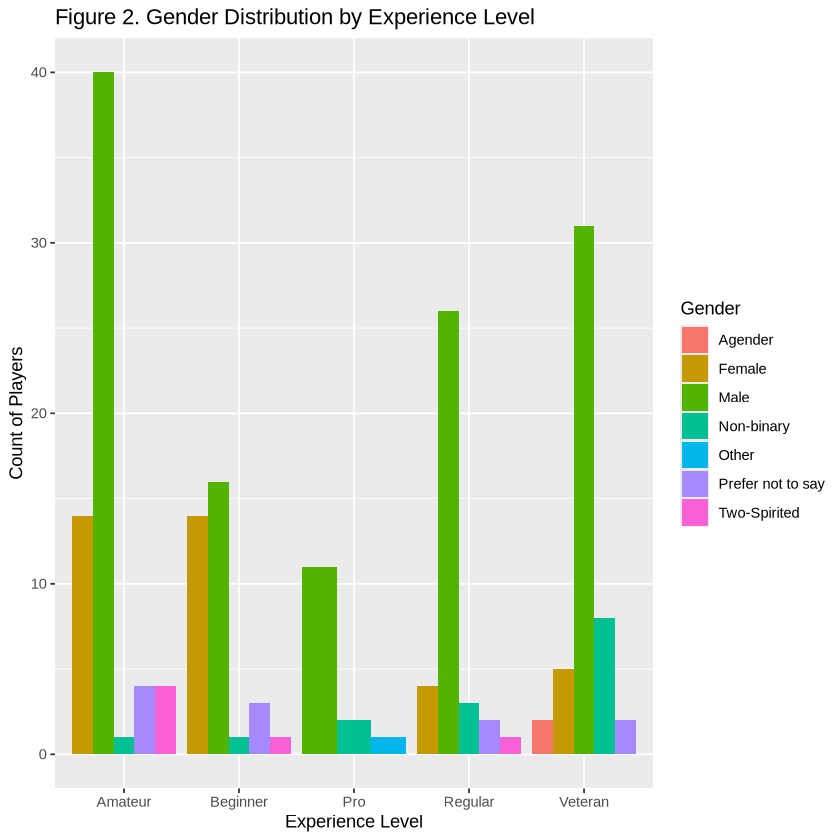

In [29]:
player_level |>
  ggplot(aes(x = experience, fill = gender)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Figure 2. Gender Distribution by Experience Level",
    x = "Experience Level",
    y = "Count of Players",
    fill = "Gender"
  )

head(player_level)

Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


,hashedEmail,name,experience,subscribe,played_hours,gender,Age,sessions_num,total_time,mean_time,median_time
,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Isaac,Regular,TRUE,1.5,Male,20,2,-22,-11.0000000,-11
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Frankie,Veteran,TRUE,0.0,Male,17,NA,NA,NA,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Lyra,Pro,FALSE,0.4,Male,21,1,0,0.0000000,0
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Osiris,Beginner,TRUE,0.1,Male,17,1,0,0.0000000,0
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Winslow,Regular,TRUE,5.6,Male,17,13,5,0.3846154,0
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Knox,Pro,TRUE,1.0,Male,17,2,2,1.0000000,1


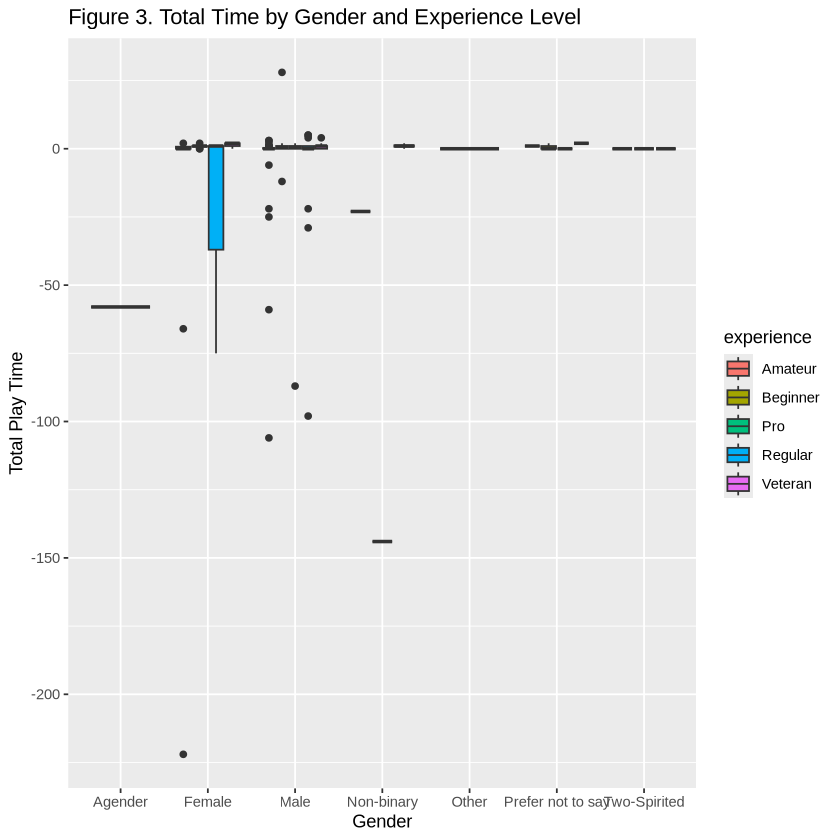

In [30]:
#Visualization 3: Total play time by gender and experience
player_level |>
  ggplot(aes(x = gender, y = total_time, fill = experience)) +
  geom_boxplot() +
  labs(
    title = "Figure 3. Total Time by Gender and Experience Level",
    x = "Gender",
    y = "Total Play Time"
  )

head(player_level)

# Discussion

Our analysis examined whether a player’s gender and total play time relate to their experience level. From the summary statistics and visualizations, we can see several patterns: 


First, the boxplot comparing total play time across experience levels (Figure 1) suggests that more experienced players tend to accumulate greater total play time. This pattern aligns with the expectation that experience is built over longer engagement with the game.


Second, gender distributions (Figure 2) indicate that genders may not be evenly represented across experience levels. While this does not establish causation, it highlights demographic differences that may contribute to differences in experience development.


Third, combining gender and experience (Figure 3) shows that the effect of gender on play time may differ across experience groups.


Overall, our findings align with behavioral expectations: **higher experience levels are generally associated with greater accumulated play time. Gender appears to influence participation patterns, although more detailed modeling would be required to investigate this relationship more precisely.**

# References